### Libraries

In [1]:
!pip install wget transformers timm scipy
import wget

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=107f291e54a89a8cd4201a74c60e37ad70440205112fc228eb05a7e4e6630266
  Stored in dire

In [2]:
import math
import os
import random
import tarfile
from typing import List, Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from timm import create_model

In [3]:
def set_random_seed(seed) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_random_seed(seed=0)

## VOC2007 Dataset

In [4]:
VOC2007_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]


def VOC_download(root_dir):
    if os.path.exists(os.path.join(root_dir, 'VOCdevkit')):
        print("VOC exists.")
        return

    urls = {
        "trainval": "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar",
        "test": "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar"
    }

    trainval_download_path = os.path.join(root_dir, "VOC2007.tar")

    print(f"Downloading VOC 2007 train/val data...")
    wget.download(urls["trainval"], trainval_download_path)

    with tarfile.open(trainval_download_path, "r") as tar:
        tar.extractall(root_dir)

    os.remove(trainval_download_path)

    test_download_path = os.path.join(root_dir, f"VOC2007_test.tar")
    print(f"\nDownloading VOC 2007 test data...")
    wget.download(urls["test"], test_download_path)

    with tarfile.open(test_download_path, "r") as tar:
        tar.extractall(root_dir)

    os.remove(test_download_path)


class VOC2007Dataset(Dataset):
    def __init__(self, root_dir, is_train=False, download=True, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform

        if download:
            VOC_download(root_dir=self.root_dir)

        image_set = 'trainval' if is_train else 'test'
        imageset_file = os.path.join(self.root_dir, "VOCdevkit", "VOC2007", "ImageSets", "Main", image_set + ".txt")

        with open(imageset_file) as f:
            self.image_ids = [x.strip() for x in f.readlines()]

        self.class_to_ind = dict(zip(VOC2007_CLASSES, range(len(VOC2007_CLASSES))))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, "VOCdevkit", "VOC2007", "JPEGImages", image_id + ".jpg")
        image = Image.open(image_path).convert("RGB")

        image_w, image_h = image.size

        annotation_path = os.path.join(self.root_dir, "VOCdevkit", "VOC2007", "Annotations", image_id + ".xml")
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        classes = []
        for obj in root.findall('object'):
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue  # skip difficult objects

            class_name = obj.find('name').text.lower().strip()
            if class_name not in self.class_to_ind:
                continue

            bbox = obj.find('bndbox')
            x1 = float(bbox.find('xmin').text)
            y1 = float(bbox.find('ymin').text)
            x2 = float(bbox.find('xmax').text)
            y2 = float(bbox.find('ymax').text)

            keep = (x1 < x2) or (y1 < y2)
            if not keep:
                continue

            boxes.append([x1, y1, x2, y2])
            classes.append(self.class_to_ind[class_name])

        classes = np.asarray(classes, dtype=np.int64)
        boxes = np.asarray(boxes, dtype=np.float32).reshape(-1, 4)

        annots = {
            'class_labels': classes,
            'boxes': boxes,
            'orig_size': np.asarray([int(image_h), int(image_w)], dtype=np.int64)
        }

        if self.transform is not None:
            image, annots = self.transform(image, annots)

        return image, annots

In [5]:
path2data = '/content/VOC'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [6]:
dataset_train = VOC2007Dataset(root_dir=path2data, is_train=True)
dataset_test = VOC2007Dataset(root_dir=path2data)


VOC exists.


## Visualization

In [7]:
def show_sample(
    image,
    annots_or_preds,
    orig_size,
    colors=None,
    unnormalize=False,
    mean=None,
    std=None,
    bbox_unnormalize=False,
    rescale=False,
    is_label=True
):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose(1, 2, 0)
    elif isinstance(image, Image.Image):
        image = np.array(image)

    if colors is None:
        colors = np.random.randint(0, 255, size=(len(VOC2007_CLASSES), 3), dtype='uint8') / 255.0

    if unnormalize:
        assert mean is not None and std is not None
        image = image * std + mean

    if rescale:
        image = image.astype(np.float32) / 255.0

    box_key = 'boxes'
    label_key = 'class_labels'
    if not is_label:
        label_key = 'labels'

        pred_labels = torch.cat([v["labels"] for v in annots_or_preds])
        pred_boxes = torch.cat([v["boxes"] for v in annots_or_preds])
        annots_or_preds = {
            box_key: pred_boxes,
            label_key: pred_labels
        }

    plt.imshow(image)
    ax = plt.gca()

    for box, class_id in zip(annots_or_preds[box_key], annots_or_preds[label_key]):
        if isinstance(box, torch.Tensor):
            box = box.detach().cpu().numpy()

        if isinstance(class_id, torch.Tensor):
            class_id = class_id.item()

        if bbox_unnormalize:
            cx, cy, w, h = box
            x1 = cx - w / 2
            y1 = cy - h / 2
        else:
            x1, y1, x2, y2 = box

            w = x2 - x1
            h = y2 - y1

        if box.min() >= 0.0 and box.max() <= 1.0 :
            orig_h, orig_w = orig_size
            x1 = x1 * orig_w
            y1 = y1 * orig_h
            w = w * orig_w
            h = h * orig_h

        class_name = VOC2007_CLASSES[class_id]

        rect = patches.Rectangle(
            (x1, y1),
            w, h,
            linewidth=1.5,
            edgecolor=colors[class_id],
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1,
            class_name,
            c='white',
            size=10,
            path_effects=[pe.withStroke(linewidth=2, foreground=colors[class_id])],
            family='sans-serif',
            weight='semibold',
            va='top', ha='left',
            bbox=dict(
                boxstyle='round',
                ec=colors[class_id],
                fc=colors[class_id],
            )
        )

    plt.axis('off')
    plt.show()

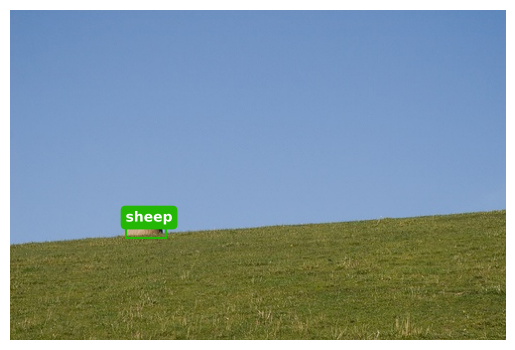

In [8]:
image, annots = dataset_train[123]
show_sample(image, annots, orig_size=annots['orig_size'], rescale=True)

## Preprocessing Images

In [9]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, annots):
        for t in self.transforms:
            image, annots = t(image, annots)
        return image, annots


class ResizeWithAspectRatio:
    def __init__(
        self,
        shortest_edge,
        longest_edge,
        resample=Image.BILINEAR
    ):
        self.shortest_edge = shortest_edge
        self.longest_edge = longest_edge
        self.resample = resample

    def __call__(self, image, annots=None):
        orig_size = annots['orig_size']
        new_size = self.get_size_with_aspect_ratio(
            orig_size, self.shortest_edge, self.longest_edge
        )
        new_height, new_width = new_size
        resized_image = image.resize((new_width, new_height), resample=self.resample)
        resized_image = np.array(resized_image)

        resized_annotation = None
        if annots is not None:
            ratios = tuple(float(s) / float(s_orig) for s, s_orig in zip(new_size, orig_size))
            ratio_height, ratio_width = ratios

            resized_annotation = {}
            resized_annotation["size"] = new_size

            for key, value in annots.items():
                if key == "boxes":
                    boxes = value
                    scaled_boxes = boxes * np.asarray([ratio_width, ratio_height, ratio_width, ratio_height], dtype=np.float32)
                    resized_annotation["boxes"] = scaled_boxes
                elif key == "area":
                    area = value
                    scaled_area = area * (ratio_width * ratio_height)
                    resized_annotation["area"] = scaled_area
                elif key == "size":
                    resized_annotation["size"] = new_size
                else:
                    resized_annotation[key] = value

        return resized_image, resized_annotation

    def get_size_with_aspect_ratio(self, image_size, size, max_size):
        height, width = image_size
        raw_size = None
        min_original_size = float(min((height, width)))
        max_original_size = float(max((height, width)))
        if max_original_size / min_original_size * size > max_size:
            raw_size = max_size * min_original_size / max_original_size
            size = int(round(raw_size))

        if (height <= width and height == size) or (width <= height and width == size):
            oh, ow = height, width
        elif width < height:
            ow = size
            if raw_size is not None:
                oh = int(raw_size * height / width)
            else:
                oh = int(size * height / width)
        else:
            oh = size
            if raw_size is not None:
                ow = int(raw_size * width / height)
            else:
                ow = int(size * width / height)

        return (oh, ow)


class Rescale:
    def __init__(self, rescale_factor):
        self.rescale_factor = rescale_factor

    def __call__(self, image, annots=None):
        rescaled_image = image.astype(np.float64) * self.rescale_factor
        rescaled_image = rescaled_image.astype(np.float32)
        return rescaled_image, annots


def corners_to_center_format(bboxes_corners):
    top_left_x, top_left_y, bottom_right_x, bottom_right_y = bboxes_corners.T
    bboxes_center = np.stack(
        [
            (top_left_x + bottom_right_x) / 2,  # center x
            (top_left_y + bottom_right_y) / 2,  # center y
            (bottom_right_x - top_left_x),  # width
            (bottom_right_y - top_left_y),  # height
        ],
        axis=-1,
    )
    return bboxes_center


class Normalize:
    def __init__(
        self,
        mean,
        std,
    ):
        self.mean = mean
        self.std = std

    def __call__(self, image, annots=None):
        normalized_image = (image - self.mean) / self.std

        norm_annotation = None
        if annots is not None:
            image_height, image_width = image.shape[:2]
            norm_annotation = {}
            for key, value in annots.items():
                if key == "boxes":
                    boxes = value
                    boxes = corners_to_center_format(boxes)
                    boxes /= np.asarray([image_width, image_height, image_width, image_height], dtype=np.float32)
                    norm_annotation[key] = boxes
                else:
                    norm_annotation[key] = value

        return normalized_image, norm_annotation


def pad(image, padded_size, annots=None):
    input_height, input_width = image.shape[:2]
    output_height, output_width = padded_size

    pad_bottom = output_height - input_height
    pad_right = output_width - input_width
    padding = ((0, pad_bottom), (0, pad_right), (0, 0))

    constant_values = ((0.0, 0.0), (0.0, 0.0), (0.0, 0.0))
    padded_image = np.pad(image, padding, mode="constant", constant_values=constant_values)

    new_annotation = None
    if annots is not None:
        new_annotation = {}
        new_annotation["size"] = padded_size

        for key, value in annots.items():
            if key == "boxes":
                boxes = value
                boxes *= np.asarray(
                    [
                        input_width / output_width,
                        input_height / output_height,
                        input_width / output_width,
                        input_height / output_height,
                    ]
                )
                new_annotation["boxes"] = boxes
            elif key == "size":
                new_annotation["size"] = padded_size
            else:
                new_annotation[key] = value

    return padded_image, new_annotation


def max_across_indices(values):
    return [max(values_i) for values_i in zip(*values)]


def get_max_height_width(images):
    max_height, max_width, _ = max_across_indices([img.shape for img in images])
    return (max_height, max_width)


def collate_fn(batch):
    images, annotation_list = zip(*batch)

    padded_size = get_max_height_width(images)

    padded_images = []
    padded_annotations = []
    for image, annotation in zip(images, annotation_list):
        padded_image, padded_annotation = pad(
            image,
            padded_size,
            annotation,
        )
        padded_images.append(padded_image)
        padded_annotations.append(padded_annotation)

    image_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in padded_images]
    image_tensors = torch.stack(image_tensors)
    annot_tensors = [
        {
            k: torch.from_numpy(v) if isinstance(v, np.ndarray) else torch.tensor(v)
            for k, v in annot.items()
        }
        for annot in padded_annotations
    ]

    return image_tensors, annot_tensors

## Implementation of DEtection TRansformer (DETR)
---
[Paper: End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872)

The DETR model was proposed in End-to-End Object Detection with Transformers by Nicolas Carion, Francisco Massa, Gabriel Synnaeve, Nicolas Usunier, Alexander Kirillov and Sergey Zagoruyko. DETR consists of a convolutional backbone followed by an encoder-decoder Transformer which can be trained end-to-end for object detection. It greatly simplifies a lot of the complexity of models like Faster-R-CNN and Mask-R-CNN, which use things like region proposals, non-maximum suppression procedure and anchor generation. Moreover, DETR can also be naturally extended to perform panoptic segmentation, by simply adding a mask head on top of the decoder outputs.

First, an image is sent through a pre-trained convolutional backbone (in the paper, the authors use ResNet-50/ResNet-101). Let’s assume we also add a batch dimension. This means that the input to the backbone is a tensor of shape (batch_size, 3, height, width), assuming the image has 3 color channels (RGB). The CNN backbone outputs a new lower-resolution feature map, typically of shape (batch_size, 2048, height/32, width/32). This is then projected to match the hidden dimension of the Transformer of DETR, which is 256 by default, using a nn.Conv2D layer. So now, we have a tensor of shape (batch_size, 256, height/32, width/32). Next, the feature map is flattened and transposed to obtain a tensor of shape (batch_size, seq_len, d_model) = (batch_size, width/32*height/32, 256). So a difference with NLP models is that the sequence length is actually longer than usual, but with a smaller d_model (which in NLP is typically 768 or higher).

Next, this is sent through the encoder, outputting encoder_hidden_states of the same shape (you can consider these as image features). Next, so-called object queries are sent through the decoder. This is a tensor of shape (batch_size, num_queries, d_model), with num_queries typically set to 100 and initialized with zeros. These input embeddings are learnt positional encodings that the authors refer to as object queries, and similarly to the encoder, they are added to the input of each attention layer. Each object query will look for a particular object in the image. The decoder updates these embeddings through multiple self-attention and encoder-decoder attention layers to output decoder_hidden_states of the same shape: (batch_size, num_queries, d_model). Next, two heads are added on top for object detection: a linear layer for classifying each object query into one of the objects or “no object”, and a MLP to predict bounding boxes for each query.

The model is trained using a bipartite matching loss: so what we actually do is compare the predicted classes + bounding boxes of each of the N = 100 object queries to the ground truth annotations, padded up to the same length N (so if an image only contains 4 objects, 96 annotations will just have a “no object” as class and “no bounding box” as bounding box). The Hungarian matching algorithm is used to find an optimal one-to-one mapping of each of the N queries to each of the N annotations. Next, standard cross-entropy (for the classes) and a linear combination of the L1 and generalized IoU loss (for the bounding boxes) are used to optimize the parameters of the model.

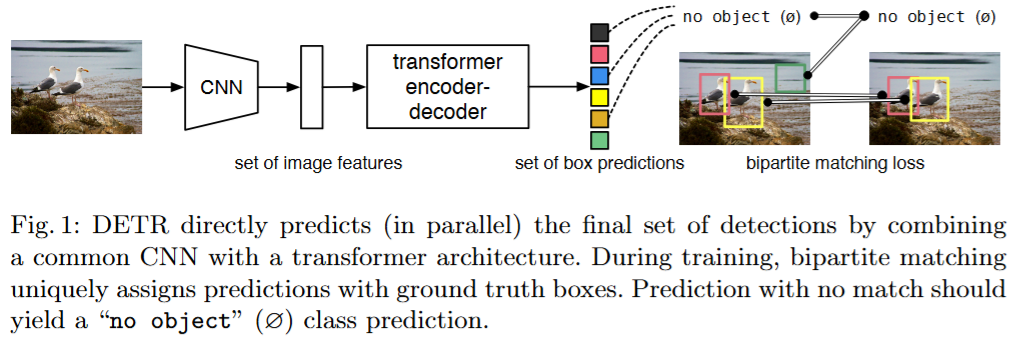

In [10]:
def _init_weights(module, init_std=0.02):
    std = init_std

    if isinstance(module, (nn.Linear, nn.Conv2d, nn.BatchNorm2d)):
        # Slightly different from the TF version which uses truncated_normal for initialization
        # cf https://github.com/pytorch/pytorch/pull/5617
        module.weight.data.normal_(mean=0.0, std=std)
        if module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=std)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()


def _prepare_4d_attention_mask(mask, dtype, tgt_len=None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


def center_to_corners_format(bboxes_center):
    center_x, center_y, width, height = bboxes_center.unbind(-1)
    bbox_corners = torch.stack(
        # top left x, top left y, bottom right x, bottom right y
        [(center_x - 0.5 * width), (center_y - 0.5 * height), (center_x + 0.5 * width), (center_y + 0.5 * height)],
        dim=-1,
    )
    return bbox_corners

### Implement a positional encoding of DETR
---
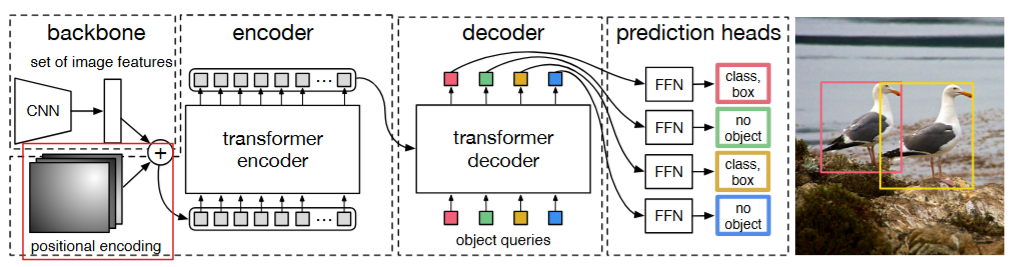

In [11]:
class DetrFrozenBatchNorm2d(nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt, without which any other models than
    torchvision.models.resnet[18,34,50,101] produce nans.
    """

    def __init__(self, n):
        super().__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def forward(self, x):
        # move reshapes to the beginning
        # to make it user-friendly
        weight = self.weight.reshape(1, -1, 1, 1)
        bias = self.bias.reshape(1, -1, 1, 1)
        running_var = self.running_var.reshape(1, -1, 1, 1)
        running_mean = self.running_mean.reshape(1, -1, 1, 1)
        epsilon = 1e-5
        scale = weight * (running_var + epsilon).rsqrt()
        bias = bias - running_mean * scale
        return x * scale + bias


def replace_batch_norm(model):
    r"""
    Recursively replace all `torch.nn.BatchNorm2d` with `DetrFrozenBatchNorm2d`.

    Args:
        model (torch.nn.Module):
            input model
    """
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            new_module = DetrFrozenBatchNorm2d(module.num_features)

            if not module.weight.device == torch.device("meta"):
                new_module.weight.data.copy_(module.weight)
                new_module.bias.data.copy_(module.bias)
                new_module.running_mean.data.copy_(module.running_mean)
                new_module.running_var.data.copy_(module.running_var)

            model._modules[name] = new_module

        if len(list(module.children())) > 0:
            replace_batch_norm(module)


class DetrConvEncoder(nn.Module):
    """
    Convolutional backbone, using either the AutoBackbone API or one from the timm library.

    nn.BatchNorm2d layers are replaced by DetrFrozenBatchNorm2d as defined above.

    """

    def __init__(self, out_indices, num_channels, backbone_model_type, pretrained=True):
        super().__init__()

        backbone = create_model(
            backbone_model_type,
            pretrained=pretrained,
            features_only=True,
            out_indices=out_indices,
            in_chans=num_channels,
        )

        # replace batch norm by frozen batch norm
        with torch.no_grad():
            replace_batch_norm(backbone)
        self.model = backbone
        self.intermediate_channel_sizes = (self.model.feature_info.channels())

        for name, parameter in self.model.named_parameters():
            if "layer2" not in name and "layer3" not in name and "layer4" not in name:
                    parameter.requires_grad_(False)

    def forward(self, images, pixel_mask):
        # send pixel_values through the model to get list of feature maps
        features = self.model(images)

        out = []
        for feature_map in features:
            # downsample pixel_mask to match shape of corresponding feature_map
            mask = nn.functional.interpolate(pixel_mask[None].float(), size=feature_map.shape[-2:]).to(torch.bool)[0]
            out.append((feature_map, mask))
        return out


class DetrConvModel(nn.Module):
    """
    This module adds 2D position embeddings to all intermediate feature maps of the convolutional encoder.
    """

    def __init__(self, conv_encoder, position_embedding):
        super().__init__()
        self.conv_encoder = conv_encoder
        self.position_embedding = position_embedding

    def forward(self, images, pixel_mask):
        # send pixel_values and pixel_mask through backbone to get list of (feature_map, pixel_mask) tuples
        out = self.conv_encoder(images, pixel_mask)
        pos = []
        for feature_map, mask in out:
            # position encoding
            pos.append(self.position_embedding(feature_map, mask).to(feature_map.dtype))

        return out, pos


class DetrSinePositionEmbedding(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one used by the Attention is all you
    need paper, generalized to work on images.
    """
    def __init__(self, embedding_dim=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, feature_map, pixel_mask):
        y_embed = pixel_mask.cumsum(1, dtype=torch.float32)
        x_embed = pixel_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            y_embed = y_embed / (y_embed[:, -1:, :] + 1e-6) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + 1e-6) * self.scale

        ##########################################
        # TODO: complete the forward function    #
        ##########################################
        # [START]
        dim_t = torch.arange(self.embedding_dim, dtype=torch.int64, device=feature_map.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        # even to sin() odd to cos(): finally (B, H, W, dim)
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)

        # (B, 2*dim, H, W)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        # [END]
        return pos


def build_position_encoding(d_model):
    n_steps = d_model // 2
    position_embedding = DetrSinePositionEmbedding(n_steps, normalize=True)

    return position_embedding

### Implement an Attention module for DETR

In [12]:
class DetrAttention(nn.Module):
    def __init__(
        self,
        embed_dim,
        num_heads,
        bias=True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {num_heads})."
            )
        self.scaling = self.head_dim**-0.5

        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        # [END]

    def _shape(self, tensor, seq_len, batch_size):
        return tensor.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def with_pos_embed(self, tensor, object_queries):
        return tensor if object_queries is None else tensor + object_queries

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        object_queries=None,
        key_value_states=None,
        spatial_position_embeddings=None,
    ):
        """Input shape: Batch x Time x Channel"""
        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None
        batch_size, target_len, embed_dim = hidden_states.size()

        hidden_states_original = hidden_states
        if object_queries is not None:
            ###############################################################################################
            # TODO: add position embeddings to the hidden states before projecting to queries and keys    #
            # HINT: use `with_pos_embed` method                                                           #
            ###############################################################################################
            # [START]
            # hidden_states_original = hidden_states
            hidden_states = self.with_pos_embed(hidden_states, object_queries)
            # [END]

        key_value_states_original = key_value_states
        if spatial_position_embeddings is not None:
            ######################################################################
            # TODO: add key-value position embeddings to the key value states    #
            # HINT: use `with_pos_embed` method                                  #
            ######################################################################
            # [START]
            # key_value_states_original = key_value_states
            key_value_states = self.with_pos_embed(key_value_states, spatial_position_embeddings)
            # [END]

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        if is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, batch_size)
            value_states = self._shape(self.v_proj(key_value_states_original), -1, batch_size)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, batch_size)
            value_states = self._shape(self.v_proj(hidden_states_original), -1, batch_size)

        proj_shape = (batch_size * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, target_len, batch_size).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        source_len = key_states.size(1)

        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        # attention score = query ∙ key.T
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (batch_size * self.num_heads, target_len, source_len):
            raise ValueError(
                f"Attention weights should be of size {(batch_size * self.num_heads, target_len, source_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (batch_size, 1, target_len, source_len):
                raise ValueError(
                    f"Attention mask should be of size {(batch_size, 1, target_len, source_len)}, but is"
                    f" {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(batch_size, self.num_heads, target_len, source_len) + attention_mask
            attn_weights = attn_weights.view(batch_size * self.num_heads, target_len, source_len)

        # softmax normalization
        attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)

        # weighted sum of value
        attn_output = torch.bmm(attn_weights, value_states)

        if attn_output.size() != (batch_size * self.num_heads, target_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(batch_size, self.num_heads, target_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(batch_size, self.num_heads, target_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(batch_size, target_len, embed_dim)

        attn_output = self.out_proj(attn_output)
        # [END]

        return attn_output

### Implement DETR encoder
---
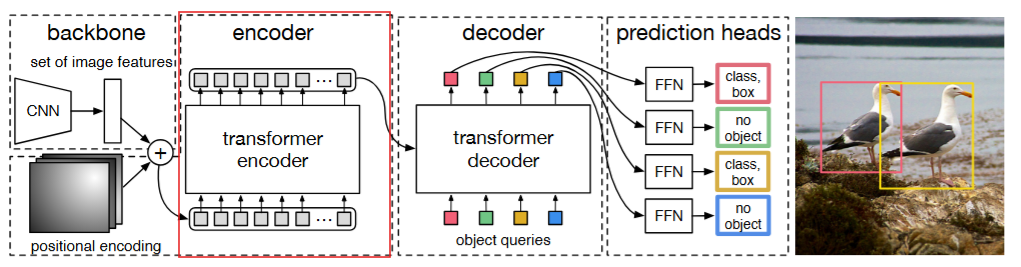

In [13]:
class DetrEncoderLayer(nn.Module):
    def __init__(
        self,
        encoder_ffn_dim,
        encoder_attention_heads,
        d_model,
        dropout=0.1,
    ):
        super().__init__()
        self.embed_dim = d_model
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        # self-attention (q, k, v)
        self.self_attn = DetrAttention(
            embed_dim = self.embed_dim,
            num_heads = encoder_attention_heads
        )
        # self-attention 이후 LayerNorm
        # Feed Forward Network (2-layer MLP) 이후 LayerNorm: fc1 → relu → fc2 → LayerNorm
        # dropout for regularization
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = dropout
        self.activation_fn = nn.ReLU()
        self.fc1 = nn.Linear(self.embed_dim, encoder_ffn_dim)
        self.fc2 = nn.Linear(encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)
        # [END]

    def forward(
        self,
        hidden_states,
        attention_mask,
        object_queries=None,
    ):
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            object_queries (`torch.FloatTensor`, *optional*):
                Object queries (also called content embeddings), to be added to the hidden states.
        """
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        # STEP 1-1: Self-Attention
        residual = hidden_states
        hidden_states = self.self_attn(
            hidden_states = hidden_states,
            attention_mask = attention_mask,
            object_queries = object_queries
        )
        # [END]

        ##########################################
        # TODO: complete the forward function    #
        ##########################################
        # [START]
        # STEP 1-2: Add & Normalize = residual connection + LayerNorm
        # residual + dropout → LayerNorm
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # STEP 2-1: FFN
        # fc1 → activation, dropout → fc2
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # STEP 2-2: Add & Normalize = residual connection + LayerNorm
        # residual + droput → LayerNorm
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)
        # [END]

        if self.training:
            if torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any():
                clamp_value = torch.finfo(hidden_states.dtype).max - 1000
                hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        return hidden_states


class DetrEncoder(nn.Module):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`DetrEncoderLayer`].

    The encoder updates the flattened feature map through multiple self-attention layers.

    Small tweak for DETR:

    - object_queries are added to the forward pass.

    Args:
        config: DetrConfig
    """

    def __init__(
        self,
        encoder_layers,
        encoder_ffn_dim,
        encoder_attention_heads,
        d_model,
        dropout=0.1,
    ):
        super().__init__()

        self.dropout = dropout

        self.layers = nn.ModuleList(
            [
                DetrEncoderLayer(
                    encoder_ffn_dim,
                    encoder_attention_heads,
                    d_model,
                    dropout,
                )
                for _ in range(encoder_layers)
            ]
        )

        # in the original DETR, no layernorm is used at the end of the encoder, as "normalize_before" is set to False by default

    def forward(
        self,
        inputs_embeds=None,
        attention_mask=None,
        object_queries=None,
    ):
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Flattened feature map (output of the backbone + projection layer) that is passed to the encoder.

            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding pixel features. Mask values selected in `[0, 1]`:

                - 1 for pixel features that are real (i.e. **not masked**),
                - 0 for pixel features that are padding (i.e. **masked**).

                [What are attention masks?](../glossary#attention-mask)

            object_queries (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Object queries that are added to the queries in each self-attention layer.
        """
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        # DETR positional encoding in each attention layer → hidden_states with only dropout here
        hidden_states = inputs_embeds
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        # [END]

        # expand attention_mask
        if attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            attention_mask = _prepare_4d_attention_mask(attention_mask, inputs_embeds.dtype)

        for i, encoder_layer in enumerate(self.layers):
            ##################################################################
            # TODO: complete the forward function                            #
            # HINT: add object_queries as extra input to the encoder_layer   #
            ##################################################################
            # [START]
            # DETR positional encoding is not directily added to the inputs → object_queries + spatial pos in each attention layer
            hidden_states = encoder_layer(
                hidden_states = hidden_states,
                attention_mask = attention_mask,
                object_queries = object_queries
            )
            # [END]

        return hidden_states

### Implement DETR decoder
---
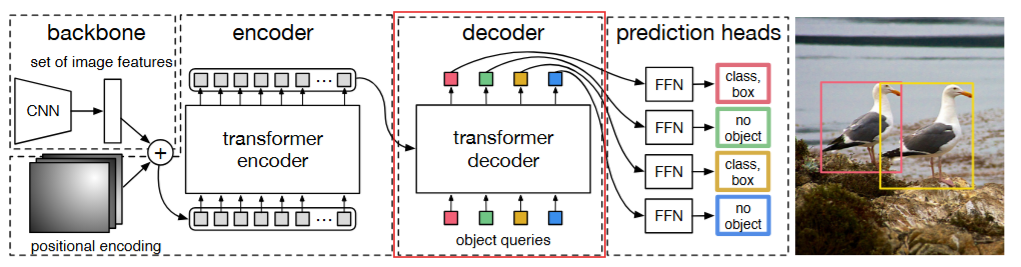

In [14]:
class DetrDecoderLayer(nn.Module):
    def __init__(
        self,
        decoder_ffn_dim,
        decoder_attention_heads,
        d_model,
        dropout=0.0,
    ):
        super().__init__()
        self.embed_dim = d_model
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        # self-attention (q, k, v)
        self.self_attn = DetrAttention(
            embed_dim = self.embed_dim,
            num_heads = decoder_attention_heads
        )
        self.dropout = dropout
        self.activation_fn = nn.ReLU()
        # self-attention 이후 LayerNorm
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        # cross-attention (q: decoder_hidden_states, k, v: encoder_hidden_states)
        self.encoder_attn = DetrAttention(
            embed_dim = self.embed_dim,
            num_heads = decoder_attention_heads
        )
        # cross-attention 이후 LayerNorm
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        # Feed Forward Network (2-layer MLP) 이후 LayerNorm: fc1 → relu → fc2 → LayerNorm
        # dropout for regularization
        self.fc1 = nn.Linear(self.embed_dim, decoder_ffn_dim)
        self.fc2 = nn.Linear(decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)
        # [END]

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        object_queries=None,
        query_position_embeddings=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            object_queries (`torch.FloatTensor`, *optional*):
                object_queries that are added to the hidden states
            in the cross-attention layer.
            query_position_embeddings (`torch.FloatTensor`, *optional*):
                position embeddings that are added to the queries and keys
            in the self-attention layer.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(batch, seq_len, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
        """
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        residual = hidden_states

        # STEP 1-1: Self-Attention
        hidden_states = self.self_attn(
            hidden_states = hidden_states,
            object_queries = query_position_embeddings,
            attention_mask = attention_mask
        )
        # STEP 1-2: Add & Normalize = residual connection + LayerNorm
        # residual + dropout → LayerNorm
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # STEP 2-1: Cross-Attention
        if encoder_hidden_states is not None:
            residual = hidden_states

            hidden_states = self.encoder_attn(
                hidden_states = hidden_states,
                object_queries = query_position_embeddings,
                key_value_states = encoder_hidden_states,
                attention_mask = encoder_attention_mask,
                spatial_position_embeddings = None
                # spatial_position_embeddings = object_queries
            )
            # STEP 2-2: Add & Normalize = residual connection + LayerNorm
            # residual + dropout → LayerNorm
            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)
        # [END]

        # Fully Connected
        ##########################################
        # TODO: complete the forward function    #
        ##########################################
        # [START]
        # STEP 3-1: FFN
        # fc1 → activation, dropout → fc2
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        # STEP 3-2: Add & Normalize = residual connection + LayerNorm
        # residual + droput → LayerNorm
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)
        # [END]

        return hidden_states


class DetrDecoder(nn.Module):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`DetrDecoderLayer`].

    The decoder updates the query embeddings through multiple self-attention and cross-attention layers.

    Some small tweaks for DETR:

    - object_queries and query_position_embeddings are added to the forward pass.
    - if self.config.auxiliary_loss is set to True, also returns a stack of activations from all decoding layers.

    Args:
        config: DetrConfig
    """

    def __init__(
        self,
        decoder_layers,
        decoder_ffn_dim,
        decoder_attention_heads,
        d_model,
        dropout=0.0,
    ):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList(
            [
                DetrDecoderLayer(
                    decoder_ffn_dim,
                    decoder_attention_heads,
                    d_model,
                    dropout=dropout,
                )
                for _ in range(decoder_layers)
            ]
        )
        # in DETR, the decoder uses layernorm after the last decoder layer output
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        self.layernorm = nn.LayerNorm(d_model)
        # [END]

    def forward(
        self,
        inputs_embeds=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        object_queries=None,
        query_position_embeddings=None,
    ):
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                The query embeddings that are passed into the decoder.

            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on certain queries. Mask values selected in `[0, 1]`:

                - 1 for queries that are **not masked**,
                - 0 for queries that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                of the decoder.
            encoder_attention_mask (`torch.LongTensor` of shape `(batch_size, encoder_sequence_length)`, *optional*):
                Mask to avoid performing cross-attention on padding pixel_values of the encoder. Mask values selected
                in `[0, 1]`:

                - 1 for pixels that are real (i.e. **not masked**),
                - 0 for pixels that are padding (i.e. **masked**).

            object_queries (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Object queries that are added to the queries and keys in each cross-attention layer.
            query_position_embeddings (`torch.FloatTensor` of shape `(batch_size, num_queries, hidden_size)`):
                , *optional*): Position embeddings that are added to the values and keys in each self-attention layer.
        """
        if inputs_embeds is not None:
            hidden_states = inputs_embeds
            input_shape = inputs_embeds.size()[:-1]

        combined_attention_mask = None

        if attention_mask is not None and combined_attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            combined_attention_mask = combined_attention_mask + _prepare_4d_attention_mask(
                attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]
            )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            encoder_attention_mask = _prepare_4d_attention_mask(
                encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]
            )

        # decoder layers
        for idx, decoder_layer in enumerate(self.layers):
            ##################################################################
            # TODO: complete the forward function                            #
            ##################################################################
            # [START]
            layer_outputs = decoder_layer(
                hidden_states = hidden_states,
                attention_mask = attention_mask,
                #attention_mask = combined_attention_mask
                object_queries = object_queries,
                query_position_embeddings = query_position_embeddings,
                encoder_hidden_states = encoder_hidden_states,
                encoder_attention_mask = encoder_attention_mask
            )
            hidden_states = layer_outputs
            # [END]

        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        hidden_states = self.layernorm(hidden_states)
        # [END]

        return hidden_states

### Implement DETR heads and complete model
---
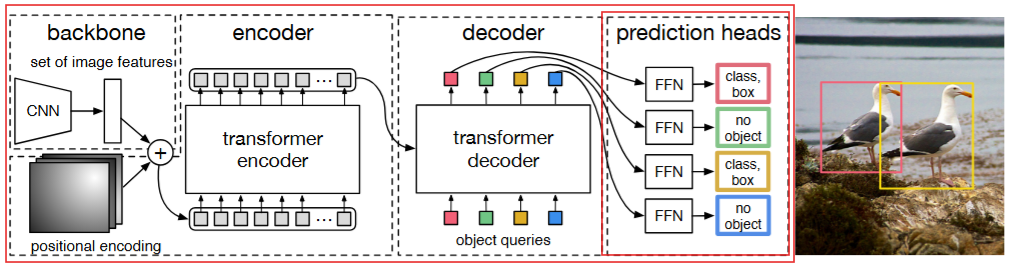

In [15]:
class DetrModel(nn.Module):
    def __init__(
        self,
        num_channels,
        num_queries,
        encoder_layers,
        encoder_ffn_dim,
        encoder_attention_heads,
        decoder_layers,
        decoder_ffn_dim,
        decoder_attention_heads,
        d_model,
        dropout=0.1,
        backbone_model_type='resnet50',
        use_pretrained_backbone=True,
        out_indices=[1, 2, 3, 4],
    ):
        super().__init__()

        # Create backbone + positional encoding
        backbone = DetrConvEncoder(
            out_indices,
            num_channels,
            backbone_model_type,
            pretrained=use_pretrained_backbone
        )
        object_queries = build_position_encoding(d_model)
        self.backbone = DetrConvModel(backbone, object_queries)

        # Create projection layer
        # Hint: use `intermediate_channel_sizes`
        self.input_projection = nn.Conv2d(
            backbone.intermediate_channel_sizes[-1], d_model, kernel_size=1
        )

        self.query_position_embeddings = nn.Embedding(num_queries, d_model)

        self.encoder = DetrEncoder(
            encoder_layers,
            encoder_ffn_dim,
            encoder_attention_heads,
            d_model,
            dropout=dropout,
        )
        self.decoder = DetrDecoder(
            decoder_layers,
            decoder_ffn_dim,
            decoder_attention_heads,
            d_model,
            dropout=dropout,
        )

    def forward(self, images):
        batch_size, num_channels, height, width = images.shape
        device = images.device

        pixel_mask = torch.ones(((batch_size, height, width)), device=device)

        # First, sent pixel_values + pixel_mask through Backbone to obtain the features
        # pixel_values should be of shape (batch_size, num_channels, height, width)
        # pixel_mask should be of shape (batch_size, height, width)
        features, object_queries_list = self.backbone(images, pixel_mask)

        # get final feature map and downsampled mask
        feature_map, mask = features[-1]

        if mask is None:
            raise ValueError("Backbone does not return downsampled pixel mask")

        # Second, apply 1x1 convolution to reduce the channel dimension to d_model (256 by default)
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]

        projected_feature_map = self.input_projection(feature_map)

        # Third, flatten the feature map + position embeddings of shape NxCxHxW to NxCxHW, and permute it to NxHWxC
        # In other words, turn their shape into (batch_size, sequence_length, hidden_size)
        flattened_features = projected_feature_map.flatten(2).permute(0, 2, 1)
        object_queries = object_queries_list[-1].flatten(2).permute(0, 2, 1)

        flattened_mask = mask.flatten(1)

        # Fourth, sent flattened_features + flattened_mask + position embeddings through encoder
        # flattened_features is a Tensor of shape (batch_size, heigth*width, hidden_size)
        # flattened_mask is a Tensor of shape (batch_size, heigth*width)
        encoder_outputs = self.encoder(
            inputs_embeds = flattened_features,
            attention_mask = flattened_mask,
            object_queries = object_queries
        )

        # Fifth, sent query embeddings + object_queries through the decoder (which is conditioned on the encoder output)
        query_position_embeddings = self.query_position_embeddings.weight.unsqueeze(0).repeat(batch_size, 1, 1)
        queries = torch.zeros_like(query_position_embeddings)

        # decoder outputs consists of (dec_features, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            inputs_embeds = queries,
            attention_mask = None,
            object_queries = object_queries,
            query_position_embeddings = query_position_embeddings,
            encoder_hidden_states = encoder_outputs,
            encoder_attention_mask = flattened_mask
        )
        # [END]

        return decoder_outputs, encoder_outputs


class DetrMLPPredictionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        ##########################################
        # TODO: fill the below incomplete code   #
        # HINT: use `nn.ModuleList`              #
        ##########################################
        # [START]
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))
        # [END]

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            ##########################################
            # TODO: fill the below incomplete code   #
            ##########################################
            # [START]
            x = nn.functional.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
            # [END]
        return x


class DetrForObjectDetection(nn.Module):
    def __init__(
        self,
        num_labels,
        num_channels,
        num_queries,
        encoder_layers,
        encoder_ffn_dim,
        encoder_attention_heads,
        decoder_layers,
        decoder_ffn_dim,
        decoder_attention_heads,
        d_model,
        dropout=0.1,
        backbone_model_type='resnet50',
        use_pretrained_backbone=True,
        out_indices=[1, 2, 3, 4],
    ):
        super().__init__()

        # DETR encoder-decoder model
        self.model = DetrModel(
            num_channels,
            num_queries,
            encoder_layers,
            encoder_ffn_dim,
            encoder_attention_heads,
            decoder_layers,
            decoder_ffn_dim,
            decoder_attention_heads,
            d_model,
            dropout=dropout,
            backbone_model_type=backbone_model_type,
            use_pretrained_backbone=use_pretrained_backbone,
            out_indices=out_indices,
        )

        # Object detection heads
        ###############################################
        # TODO: fill the below incomplete code        #
        # NOTICE: add one for the "no object" class   #
        ###############################################
        # [START]
        self.class_labels_classifier = nn.Linear(d_model, num_labels + 1)
        self.bbox_predictor = DetrMLPPredictionHead(
            input_dim = d_model,
            hidden_dim = d_model,
            output_dim = 4,
            num_layers = 3
        )
        # [END]

        # Initialize weights and apply final processing
        for m in self.modules():
            _init_weights(m)

    def forward(self, images):
        ##########################################
        # TODO: fill the below incomplete code   #
        ##########################################
        # [START]
        # First, sent images through DETR base model to obtain encoder + decoder outputs
        outputs = self.model(images)

        sequence_output = outputs[0]

        # class logits + predicted bounding boxes
        logits = self.class_labels_classifier(sequence_output)
        pred_boxes = self.bbox_predictor(sequence_output).sigmoid()
        # [END]

        outputs = {
            'logits': logits,
            'pred_boxes': pred_boxes,
        }

        return outputs

    def post_process(self, outputs, threshold=0.5, target_sizes=None):
        """
        Converts the raw output of DETR into final bounding boxes in (top_left_x, top_left_y,
        bottom_right_x, bottom_right_y) format. Only supports PyTorch.

        Args:
            outputs ([`Dict[str, torch.Tensor]`]):
                Raw outputs of the model.
            threshold (`float`, *optional*):
                Score threshold to keep object detection predictions.
            target_sizes (`torch.Tensor` or `List[Tuple[int, int]]`, *optional*):
                Tensor of shape `(batch_size, 2)` or list of tuples (`Tuple[int, int]`) containing the target size
                `(height, width)` of each image in the batch. If unset, predictions will not be resized.
        Returns:
            `List[Dict]`: A list of dictionaries, each dictionary containing the scores, labels and boxes for an image
            in the batch as predicted by the model.
        """
        out_logits = outputs['logits']
        out_bbox = outputs['pred_boxes']

        if target_sizes is not None:
            if len(out_logits) != len(target_sizes):
                raise ValueError(
                    "Make sure that you pass in as many target sizes as the batch dimension of the logits"
                )

        prob = nn.functional.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # Convert to [x1, y1, x2, y2] format
        boxes = center_to_corners_format(out_bbox)

        # Convert from relative [0, 1] to absolute [0, height] coordinates
        if target_sizes is not None:
            if isinstance(target_sizes, List):
                img_h = torch.Tensor([i[0] for i in target_sizes])
                img_w = torch.Tensor([i[1] for i in target_sizes])
            else:
                img_h, img_w = target_sizes.unbind(1)

            scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1).to(boxes.device)
            boxes = boxes * scale_fct[:, None, :]

        results = []
        for s, l, b in zip(scores, labels, boxes):
            score = s[s > threshold]
            label = l[s > threshold]
            box = b[s > threshold]
            results.append({"scores": score, "labels": label, "boxes": box})

        return results

## Loss function of DETR
---
### Implement the following loss functions for DETR
- Hungarian matcher (contained in Hungarian loss)
- object loss (contained in Hungarian loss)
- class loss
- bounding box loss
- GIoU loss

In [16]:
def _upcast(t):
    # Protects from numerical overflows in multiplications by upcasting to the equivalent higher type
    if t.is_floating_point():
        return t if t.dtype in (torch.float32, torch.float64) else t.float()
    else:
        return t if t.dtype in (torch.int32, torch.int64) else t.int()


def center_to_corners_format(bboxes_center):
    center_x, center_y, width, height = bboxes_center.unbind(-1)
    bbox_corners = torch.stack(
        # top left x, top left y, bottom right x, bottom right y
        [(center_x - 0.5 * width), (center_y - 0.5 * height), (center_x + 0.5 * width), (center_y + 0.5 * height)],
        dim=-1,
    )
    return bbox_corners


def box_area(boxes):
    """
    Computes the area of a set of bounding boxes, which are specified by its (x1, y1, x2, y2) coordinates.

    Args:
        boxes (`torch.FloatTensor` of shape `(number_of_boxes, 4)`):
            Boxes for which the area will be computed. They are expected to be in (x1, y1, x2, y2) format with `0 <= x1
            < x2` and `0 <= y1 < y2`.

    Returns:
        `torch.FloatTensor`: a tensor containing the area for each box.
    """
    boxes = _upcast(boxes)
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])


def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    left_top = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    right_bottom = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    width_height = (right_bottom - left_top).clamp(min=0)  # [N,M,2]
    inter = width_height[:, :, 0] * width_height[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / union
    return iou, union


def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/. The boxes should be in [x1, y1, x2, y2] (corner) format.

    Returns:
        `torch.FloatTensor`: a [N, M] pairwise matrix, where N = len(boxes1) and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    if not (boxes1[:, 2:] >= boxes1[:, :2]).all():
        raise ValueError(f"boxes1 must be in [x1, y1, x2, y2] (corner) format, but got {boxes1}")
    if not (boxes2[:, 2:] >= boxes2[:, :2]).all():
        raise ValueError(f"boxes2 must be in [x1, y1, x2, y2] (corner) format, but got {boxes2}")
    iou, union = box_iou(boxes1, boxes2)

    top_left = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    bottom_right = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    width_height = (bottom_right - top_left).clamp(min=0)  # [N,M,2]
    area = width_height[:, :, 0] * width_height[:, :, 1]

    return iou - (area - union) / area

In [17]:
from scipy.optimize import linear_sum_assignment


class HungarianMatcher(nn.Module):
    """
    This class computes an assignment between the targets and the predictions of the network.

    For efficiency reasons, the targets don't include the no_object. Because of this, in general, there are more
    predictions than targets. In this case, we do a 1-to-1 matching of the best predictions, while the others are
    un-matched (and thus treated as non-objects).

    Args:
        class_cost:
            The relative weight of the classification error in the matching cost.
        bbox_cost:
            The relative weight of the L1 error of the bounding box coordinates in the matching cost.
        giou_cost:
            The relative weight of the giou loss of the bounding box in the matching cost.
    """

    def __init__(self, class_cost, bbox_cost, giou_cost):
        super().__init__()

        self.class_cost = class_cost
        self.bbox_cost = bbox_cost
        self.giou_cost = giou_cost

    @torch.no_grad()
    def forward(self, outputs, targets):
        """
        Args:
            outputs (`dict`):
                A dictionary that contains at least these entries:
                * "logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                * "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates.
            targets (`List[dict]`):
                A list of targets (len(targets) = batch_size), where each target is a dict containing:
                * "class_labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of
                  ground-truth
                 objects in the target) containing the class labels
                * "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates.

        Returns:
            `List[Tuple]`: A list of size `batch_size`, containing tuples of (index_i, index_j) where:
            - index_i is the indices of the selected predictions (in order)
            - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds: len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        batch_size, num_queries = outputs["logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        target_ids = torch.cat([v["class_labels"] for v in targets])
        target_bbox = torch.cat([v["boxes"] for v in targets])

        ######################################################
        # TODO: fill the below incomplete code               #
        ######################################################
        # [START]

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        class_cost = -out_prob[:, target_ids]

        # Compute the L1 cost between boxes
        bbox_cost = torch.cdist(out_bbox, target_bbox, p=1)

        # Compute the giou cost between boxes
        giou_cost = -generalized_box_iou(center_to_corners_format(out_bbox), center_to_corners_format(target_bbox))

        # Final cost matrix
        cost_matrix = self.class_cost * class_cost + self.bbox_cost * bbox_cost + self.giou_cost * giou_cost
        # [END]
        cost_matrix = cost_matrix.view(batch_size, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(cost_matrix.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

In [18]:
class DetrLoss(nn.Module):
    def __init__(
        self,
        num_classes,
        eos_coef,
        class_cost,
        bbox_cost,
        giou_cost,
        bbox_loss_coefficient,
        giou_loss_coefficient
    ):
        super().__init__()
        self.matcher = HungarianMatcher(
            class_cost=class_cost,
            bbox_cost=bbox_cost,
            giou_cost=giou_cost
        )
        self.num_classes = num_classes
        self.eos_coef = eos_coef
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer("empty_weight", empty_weight)
        self.bbox_loss_coefficient = bbox_loss_coefficient
        self.giou_loss_coefficient = giou_loss_coefficient

    def _get_source_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(source, i) for i, (source, _) in enumerate(indices)])
        source_idx = torch.cat([source for (source, _) in indices])
        return batch_idx, source_idx

    def compute_loss_labels(self, outputs, targets, indices, num_boxes):
        """
        Classification loss (NLL) targets dicts must contain the key "class_labels" containing a tensor of dim
        [nb_target_boxes]
        """
        if "logits" not in outputs:
            raise KeyError("No logits were found in the outputs")
        source_logits = outputs["logits"]

        idx = self._get_source_permutation_idx(indices)
        target_classes_o = torch.cat([t["class_labels"][J] for t, (_, J) in zip(targets, indices)])
        #######################################################################################
        # TODO: fill the below incomplete code                                                #
        # HINT: for `loss_ce` variable, use `nn.functional` library and `self.empty_weight`   #
        #######################################################################################
        # [START]
        target_classes = torch.full(source_logits.shape[:2], self.num_classes, dtype=torch.int64, device=source_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = nn.functional.cross_entropy(source_logits.transpose(1, 2), target_classes, self.empty_weight)
        # [END]
        losses = {"loss_ce": loss_ce}

        return losses

    @torch.no_grad()
    def compute_loss_object(self, outputs, targets, indices, num_boxes):
        """
        Compute the object loss, i.e. the absolute error in the number of predicted non-empty boxes.

        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients.
        """
        logits = outputs["logits"]
        device = logits.device
        target_lengths = torch.as_tensor([len(v["class_labels"]) for v in targets], device=device)
        #
        ##############################################################################################
        # TODO: fill the below incomplete code                                                       #
        # HINT: Count the number of predictions that are NOT "no-object" (which is the last class)   #
        # HINT: for `object_error` variable, use `nn.functional` library                             #
        ##############################################################################################
        # [START]
        card_pred = (logits.argmax(dim=-1) != self.num_classes).sum(dim=1)
        object_error = nn.functional.l1_loss(card_pred.float(), target_lengths.float())
        # [END]
        losses = {"object_error": object_error}
        return losses

    def compute_loss_boxes(self, outputs, targets, indices, num_boxes):
        """
        Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss.

        Targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]. The target boxes
        are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        if "pred_boxes" not in outputs:
            raise KeyError("No predicted boxes found in outputs")
        idx = self._get_source_permutation_idx(indices)
        source_boxes = outputs["pred_boxes"][idx]
        target_boxes = torch.cat([t["boxes"][i] for t, (_, i) in zip(targets, indices)], dim=0)

        #################################################################
        # TODO: fill the below incomplete code                          #
        # HINT: for `loss_bbox` variable, use `nn.functional` library   #
        #################################################################
        # [START]
        loss_bbox = nn.functional.l1_loss(source_boxes, target_boxes, reduction='none')
        # [END]

        losses = {}
        losses["loss_bbox"] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(
            generalized_box_iou(center_to_corners_format(source_boxes), center_to_corners_format(target_boxes))
        )
        losses["loss_giou"] = loss_giou.sum() / num_boxes
        return losses

    def forward(self, outputs, targets):
        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs, targets)

        # Compute the average number of target boxes across all nodes, for normalization purposes
        num_boxes = sum(len(t["class_labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        num_boxes = torch.clamp(num_boxes, min=1).item()

        # Compute all the requested losses
        loss_dict = {}
        label_loss = self.compute_loss_labels(outputs, targets, indices, num_boxes)
        loss_dict.update(label_loss)
        object_loss = self.compute_loss_object(outputs, targets, indices, num_boxes)
        loss_dict.update(object_loss)
        box_loss = self.compute_loss_boxes(outputs, targets, indices, num_boxes)
        loss_dict.update(box_loss)

        weight_dict = {"loss_ce": 1, "loss_bbox": self.bbox_loss_coefficient}
        weight_dict["loss_giou"] = self.giou_loss_coefficient

        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        return loss, loss_dict

## Training

In [19]:
!pip install safetensors
!git lfs install
!git clone https://huggingface.co/facebook/detr-resnet-50

Git LFS initialized.
Cloning into 'detr-resnet-50'...
remote: Enumerating objects: 84, done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 84 (from 1)
Unpacking objects: 100% (84/84), 17.94 KiB | 966.00 KiB/s, done.
Filtering content: 100% (2/2), 317.88 MiB | 174.53 MiB/s, done.


In [20]:
# hyperparameters for image preprocessing
SHORTEST_EDGE = 800
LONGEST_EDGE = 1333
RESCALE_FACTOR = 1 / 255
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# hyperparameters for the model
NUM_QUERIES = 100
ENCODER_LAYERS = 6
ENCODER_FFN_DIM = 2048
ENCODER_ATTENTION_HEADS = 8
DECODER_LAYERS = 6
DECODER_FFN_DIM = 2048
DECODER_ATTENTION_HEADS = 8
D_MODEL = 256
DROPOUT_RATE = 0.1
BACKBONE_MODEL_TYPE = 'resnet50'
USE_PRETRAINED_BACKBONE = True
OUT_INDICES = [1, 2, 3, 4]

# hyperparameters for the loss function
EOS_COEFFICIENT = 0.1
CLASS_COST = 1
BBOX_COST = 5
GIOU_COST = 2
BBOX_LOSS_COEFFICIENT = 5
GIOU_LOSS_COEFFICIENT = 2

# hyperparameters for training
NUM_EPOCHS = 40
BATCH_SIZE = 8

# hyperparameters for inference
CONF_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

In [21]:
from collections import OrderedDict
from safetensors.torch import load_file


transform = Compose([
    ResizeWithAspectRatio(
        shortest_edge=SHORTEST_EDGE,
        longest_edge=LONGEST_EDGE,
    ),
    Rescale(rescale_factor=RESCALE_FACTOR),
    Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
    ),
])

dataset_train = VOC2007Dataset(root_dir=path2data, is_train=True, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DetrForObjectDetection(
    num_labels=20,
    num_channels=3,
    num_queries=NUM_QUERIES,
    encoder_layers=ENCODER_LAYERS,
    encoder_ffn_dim=ENCODER_FFN_DIM,
    encoder_attention_heads=ENCODER_ATTENTION_HEADS,
    decoder_layers=DECODER_LAYERS,
    decoder_ffn_dim=DECODER_FFN_DIM,
    decoder_attention_heads=DECODER_ATTENTION_HEADS,
    d_model=D_MODEL,
    dropout=DROPOUT_RATE,
    backbone_model_type=BACKBONE_MODEL_TYPE,
    use_pretrained_backbone=USE_PRETRAINED_BACKBONE,
    out_indices=OUT_INDICES,
)

# load pre-trained checkpoint of DETR from huggingface
ckpt_path = '/content/detr-resnet-50/model.safetensors'
state_dict = load_file(ckpt_path)
filtered_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_k = '.'.join(k.split('.')[1:])
    if k.endswith('downsample.1.num_batches_tracked'):
        continue
    if k.startswith('bbox_predictor'):
        continue
    if k.startswith('class_labels_classifier'):
        continue
    filtered_state_dict[new_k] = v
model.model.load_state_dict(filtered_state_dict)

box_head_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('bbox_predictor'):
        new_k = k.replace('bbox_predictor.', '')
        box_head_state_dict[new_k] = v
model.bbox_predictor.load_state_dict(box_head_state_dict)

model = model.to(device)

loss_fn = DetrLoss(
    num_classes=20,
    eos_coef=EOS_COEFFICIENT,
    class_cost=CLASS_COST,
    bbox_cost=BBOX_COST,
    giou_cost=GIOU_COST,
    bbox_loss_coefficient=BBOX_LOSS_COEFFICIENT,
    giou_loss_coefficient=GIOU_LOSS_COEFFICIENT,
)
loss_fn = loss_fn.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

size = len(dataloader_train.dataset)
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch, (images, annots) in enumerate(dataloader_train):
        # show_sample(images[0], annots[0], orig_size=annots[0]['size'], unnormalize=True, mean=IMAGENET_MEAN, std=IMAGENET_STD)
        # show_sample(images[1], annots[1], orig_size=annots[1]['size'], unnormalize=True, mean=IMAGENET_MEAN, std=IMAGENET_STD)

        images = images.float().to(device)
        annots = [{k: v.to(device) for k, v in t.items()} for t in annots]

        outputs = model(images)
        loss, loss_dict = loss_fn(outputs, annots)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            current = batch * len(images)
            message = '[Epoch {}: {:>4d}/{:>4d}] total loss: {:>4f}, cls loss: {:>4f}, box loss: {:>4f}, giou loss: {:>4f}, obj loss: {:>4f}'
            message = message.format(
                epoch,
                current,
                size,
                loss,
                loss_dict['loss_ce'],
                loss_dict['loss_bbox'],
                loss_dict['loss_giou'],
                loss_dict['object_error'],
            )
            print(message)

    torch.save(model.state_dict(), 'detr_voc2007.pt')
    print(f'model ckpt is saved at `./detr_voc2007.pt`.')

VOC exists.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[Epoch 0:    0/5011] total loss: 3.997020, cls loss: 3.057351, box loss: 0.086634, giou loss: 0.253250, obj loss: 96.000000
[Epoch 0:   80/5011] total loss: 3.955483, cls loss: 3.009827, box loss: 0.061605, giou loss: 0.318816, obj loss: 90.125000
[Epoch 0:  160/5011] total loss: 3.504436, cls loss: 2.939083, box loss: 0.050788, giou loss: 0.155706, obj loss: 92.250000
[Epoch 0:  240/5011] total loss: 3.755430, cls loss: 2.874008, box loss: 0.082679, giou loss: 0.234014, obj loss: 86.250000
[Epoch 0:  320/5011] total loss: 3.268589, cls loss: 2.752376, box loss: 0.040998, giou loss: 0.155613, obj loss: 64.375000
[Epoch 0:  400/5011] total loss: 3.139250, cls loss: 2.700780, box loss: 0.040772, giou loss: 0.117304, obj loss: 70.500000
[Epoch 0:  480/5011] total loss: 2.899812, cls loss: 2.524712, box loss: 0.035100, giou loss: 0.099800, obj loss: 40.875000
[Epoch 0:  560/5011] total loss: 2.989851, cls loss: 2.566422, box loss: 0.041362, giou loss: 0.108309, obj loss: 36.000000
[Epoch 0

## Inference

In [22]:
def calculate_ap(tp, fp, n_gt):
    tp_cum = torch.cumsum(tp, dim=0)
    fp_cum = torch.cumsum(fp, dim=0)
    recall = tp_cum / (n_gt + 1e-6)
    precision = tp_cum / (tp_cum + fp_cum + 1e-6)

    ap = 0
    for t in torch.arange(0, 1.1, 0.1):
        if (recall >= t).any():
            p = precision[recall >= t].max()
        else:
            p = 0.0
        ap += p / 11
    return ap


def map_iou(outputs, labels, num_classes=20, iou_thr=0.5):
    gt_labels = torch.cat([v["class_labels"] for v in labels])
    gt_boxes = torch.cat([v["boxes"] for v in labels])

    pred_labels = torch.cat([v["labels"] for v in outputs])
    pred_boxes = torch.cat([v["boxes"] for v in outputs])
    pred_scores = torch.cat([v["scores"] for v in outputs])

    aps = []
    for cls in range(num_classes):
        gt_idx = (gt_labels == cls)
        pred_idx = (pred_labels == cls)
        n_gt = gt_idx.sum().item()
        n_pred = pred_idx.sum().item()
        if n_gt == 0 and n_pred == 0:
            continue
        if n_gt == 0:
            aps.append(torch.tensor(0.))
            continue

        cur_gt_boxes = gt_boxes[gt_idx]
        cur_pred_boxes = pred_boxes[pred_idx]
        cur_pred_scores = pred_scores[pred_idx]

        # 예측 confidence로 내림차순 정렬
        if n_pred > 0:
            order = torch.argsort(cur_pred_scores, descending=True)
            cur_pred_boxes = cur_pred_boxes[order]
        else:
            aps.append(torch.tensor(0.))
            continue

        matched = torch.zeros(len(cur_gt_boxes)).bool()
        tp = torch.zeros(len(cur_pred_boxes))
        fp = torch.zeros(len(cur_pred_boxes))

        ious, _ = box_iou(cur_pred_boxes, cur_gt_boxes)  # [N_pred, N_gt]

        for i in range(len(cur_pred_boxes)):
            if ious.shape[1] == 0:
                fp[i] = 1
                continue
            iou, gt_idx_max = ious[i].max(0)
            if iou >= iou_thr and not matched[gt_idx_max]:
                tp[i] = 1
                matched[gt_idx_max] = True
            else:
                fp[i] = 1

        ap = calculate_ap(tp, fp, n_gt)
        aps.append(ap)
    if len(aps) == 0:
        return 0.0
    return torch.stack(aps).mean().item()

In [23]:
transform = Compose([
    ResizeWithAspectRatio(
        shortest_edge=SHORTEST_EDGE,
        longest_edge=LONGEST_EDGE,
    ),
    Rescale(rescale_factor=RESCALE_FACTOR),
    Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
    ),
])

dataset_test = VOC2007Dataset(root_dir=path2data, is_train=False, transform=transform)
dataloader_test = DataLoader(
    dataset_test, batch_size=BATCH_SIZE, num_workers=2, collate_fn=collate_fn
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
state_dict = torch.load('detr_voc2007.pt', map_location='cuda')
model = DetrForObjectDetection(
    num_labels=20,
    num_channels=3,
    num_queries=NUM_QUERIES,
    encoder_layers=ENCODER_LAYERS,
    encoder_ffn_dim=ENCODER_FFN_DIM,
    encoder_attention_heads=ENCODER_ATTENTION_HEADS,
    decoder_layers=DECODER_LAYERS,
    decoder_ffn_dim=DECODER_FFN_DIM,
    decoder_attention_heads=DECODER_ATTENTION_HEADS,
    d_model=D_MODEL,
    dropout=DROPOUT_RATE,
    backbone_model_type=BACKBONE_MODEL_TYPE,
    use_pretrained_backbone=USE_PRETRAINED_BACKBONE,
    out_indices=OUT_INDICES,
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

num_batches = len(dataloader_test)
test_map_iou = 0
with torch.no_grad():
    for images, annots in dataloader_test:
        images = images.float().to(device)
        annots = [{k: v.to(device) for k, v in t.items()} for t in annots]
        for batch_id in range(len(annots)):
            for box_id in range(len(annots[batch_id]['boxes'])):
                cx, cy, w, h = annots[batch_id]['boxes'][box_id]
                x1 = cx - w / 2
                y1 = cy - h / 2
                x2 = x1 + w
                y2 = y1 + h
                annots[batch_id]['boxes'][box_id][0] = x1
                annots[batch_id]['boxes'][box_id][1] = y1
                annots[batch_id]['boxes'][box_id][2] = x2
                annots[batch_id]['boxes'][box_id][3] = y2

        outputs = model(images)
        processed_outputs = model.post_process(outputs, threshold=CONF_THRESHOLD)

        test_map_iou += map_iou(
            processed_outputs, annots, num_classes=20, iou_thr=IOU_THRESHOLD
        )

    test_map_iou /= num_batches

print(f'Test mAP: {test_map_iou:>8f}')

VOC exists.
Test mAP: 0.675579


### Visualization: Ground truth

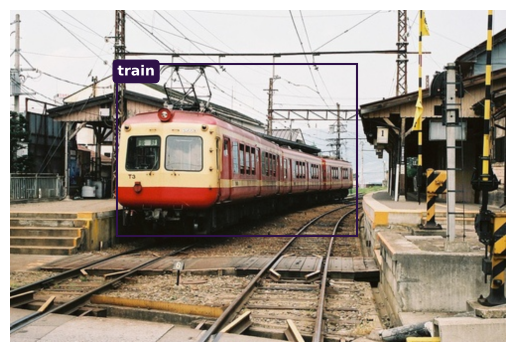

In [24]:
image, annots = dataset_test[123]
show_sample(image, annots, orig_size=annots['size'], unnormalize=True, mean=IMAGENET_MEAN, std=IMAGENET_STD, bbox_unnormalize=True)

### Visualization: Prediction

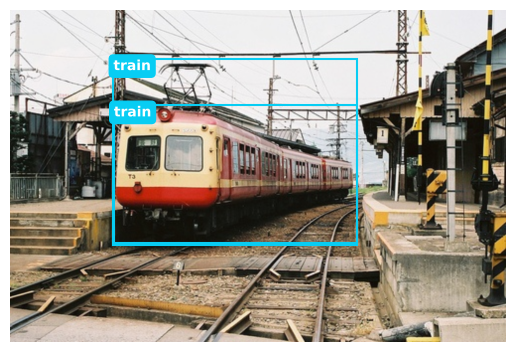

In [25]:
image, annots = dataset_test[123]

images = [image]
annotation_list = [annots]

padded_size = get_max_height_width(images)

padded_images = []
padded_annotations = []
for image, annotation in zip(images, annotation_list):
    padded_image, padded_annotation = pad(
        image,
        padded_size,
        annotation,
    )
    padded_images.append(padded_image)
    padded_annotations.append(padded_annotation)

image_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in padded_images]
image_tensors = torch.stack(image_tensors)
annot_tensors = [
    {
        k: torch.from_numpy(v) if isinstance(v, np.ndarray) else torch.tensor(v)
        for k, v in annot.items()
    }
    for annot in padded_annotations
]
image_tensors = image_tensors.float().to(device)

outputs = model(image_tensors)
processed_outputs = model.post_process(outputs, threshold=CONF_THRESHOLD)
show_sample(
    image_tensors[0].permute(1, 2, 0).detach().cpu().numpy(),
    processed_outputs,
    orig_size=annot_tensors[0]['size'],
    unnormalize=True,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    is_label=False
)

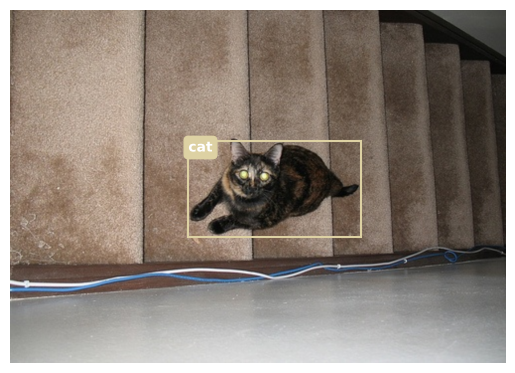

In [26]:
image, annots = dataset_test[23]

images = [image]
annotation_list = [annots]

padded_size = get_max_height_width(images)

padded_images = []
padded_annotations = []
for image, annotation in zip(images, annotation_list):
    padded_image, padded_annotation = pad(
        image,
        padded_size,
        annotation,
    )
    padded_images.append(padded_image)
    padded_annotations.append(padded_annotation)

image_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in padded_images]
image_tensors = torch.stack(image_tensors)
annot_tensors = [
    {
        k: torch.from_numpy(v) if isinstance(v, np.ndarray) else torch.tensor(v)
        for k, v in annot.items()
    }
    for annot in padded_annotations
]
image_tensors = image_tensors.float().to(device)

outputs = model(image_tensors)
processed_outputs = model.post_process(outputs, threshold=CONF_THRESHOLD)
show_sample(
    image_tensors[0].permute(1, 2, 0).detach().cpu().numpy(),
    processed_outputs,
    orig_size=annot_tensors[0]['size'],
    unnormalize=True,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    is_label=False
)

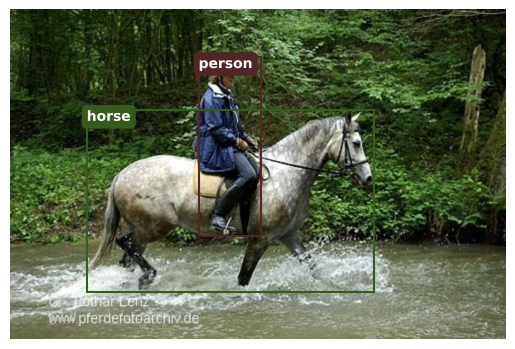

In [27]:
image, annots = dataset_test[12]

images = [image]
annotation_list = [annots]

padded_size = get_max_height_width(images)

padded_images = []
padded_annotations = []
for image, annotation in zip(images, annotation_list):
    padded_image, padded_annotation = pad(
        image,
        padded_size,
        annotation,
    )
    padded_images.append(padded_image)
    padded_annotations.append(padded_annotation)

image_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in padded_images]
image_tensors = torch.stack(image_tensors)
annot_tensors = [
    {
        k: torch.from_numpy(v) if isinstance(v, np.ndarray) else torch.tensor(v)
        for k, v in annot.items()
    }
    for annot in padded_annotations
]
image_tensors = image_tensors.float().to(device)

outputs = model(image_tensors)
processed_outputs = model.post_process(outputs, threshold=CONF_THRESHOLD)
show_sample(
    image_tensors[0].permute(1, 2, 0).detach().cpu().numpy(),
    processed_outputs,
    orig_size=annot_tensors[0]['size'],
    unnormalize=True,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    is_label=False
)

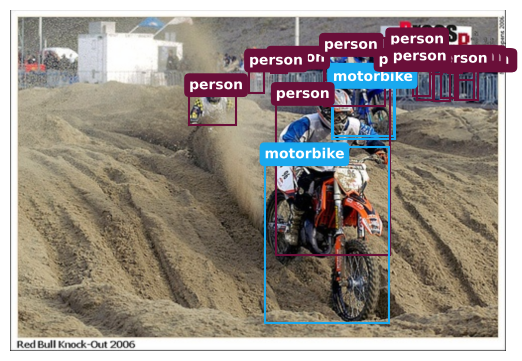

In [28]:
image, annots = dataset_test[100]

images = [image]
annotation_list = [annots]

padded_size = get_max_height_width(images)

padded_images = []
padded_annotations = []
for image, annotation in zip(images, annotation_list):
    padded_image, padded_annotation = pad(
        image,
        padded_size,
        annotation,
    )
    padded_images.append(padded_image)
    padded_annotations.append(padded_annotation)

image_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in padded_images]
image_tensors = torch.stack(image_tensors)
annot_tensors = [
    {
        k: torch.from_numpy(v) if isinstance(v, np.ndarray) else torch.tensor(v)
        for k, v in annot.items()
    }
    for annot in padded_annotations
]
image_tensors = image_tensors.float().to(device)

outputs = model(image_tensors)
processed_outputs = model.post_process(outputs, threshold=CONF_THRESHOLD)
show_sample(
    image_tensors[0].permute(1, 2, 0).detach().cpu().numpy(),
    processed_outputs,
    orig_size=annot_tensors[0]['size'],
    unnormalize=True,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    is_label=False
)

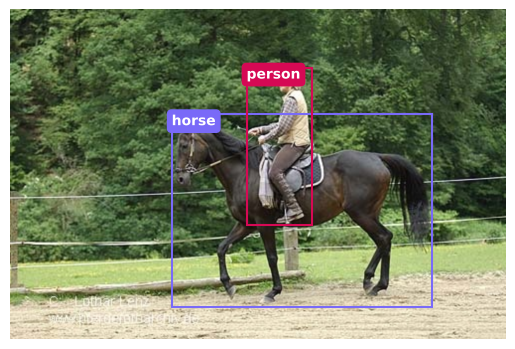

In [29]:
image, annots = dataset_test[199]

images = [image]
annotation_list = [annots]

padded_size = get_max_height_width(images)

padded_images = []
padded_annotations = []
for image, annotation in zip(images, annotation_list):
    padded_image, padded_annotation = pad(
        image,
        padded_size,
        annotation,
    )
    padded_images.append(padded_image)
    padded_annotations.append(padded_annotation)

image_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in padded_images]
image_tensors = torch.stack(image_tensors)
annot_tensors = [
    {
        k: torch.from_numpy(v) if isinstance(v, np.ndarray) else torch.tensor(v)
        for k, v in annot.items()
    }
    for annot in padded_annotations
]
image_tensors = image_tensors.float().to(device)

outputs = model(image_tensors)
processed_outputs = model.post_process(outputs, threshold=CONF_THRESHOLD)
show_sample(
    image_tensors[0].permute(1, 2, 0).detach().cpu().numpy(),
    processed_outputs,
    orig_size=annot_tensors[0]['size'],
    unnormalize=True,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    is_label=False
)

In [30]:
import pandas as pd

model.eval()  # Set model to evaluation mode

results = []
replacement = '0.0 1 0.0 0.0 10.0 10.0'
image_ids = dataset_test.image_ids
map_iou_total = 0
num_images = len(dataset_test)

with torch.no_grad():  # Disable gradient computation
    for idx, image_id in enumerate(image_ids):
        # Load image and annotation
        raw_img, raw_ann = dataset_test[idx]
        orig_h, orig_w = raw_ann["orig_size"]

        # Compute padded size and apply padding
        padded_h, padded_w = get_max_height_width([raw_img])
        padded_img, padded_ann = pad(raw_img, (padded_h, padded_w), raw_ann)

        # Convert image to tensor (CHW format with batch dimension)
        img_tensor = torch.from_numpy(padded_img).permute(2, 0, 1).float().unsqueeze(0).to(device)

        # Convert annotations to tensor format
        ann_tensor = {
            k: torch.from_numpy(v).to(device) if isinstance(v, np.ndarray) else torch.tensor(v).to(device)
            for k, v in padded_ann.items()
        }

        # Convert box format from (cx, cy, w, h) to (x1, y1, x2, y2)
        if 'boxes' in ann_tensor:
            boxes = ann_tensor['boxes']
            cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
            x1 = cx - w / 2
            y1 = cy - h / 2
            x2 = cx + w / 2
            y2 = cy + h / 2
            ann_tensor['boxes'] = torch.stack([x1, y1, x2, y2], dim=1)

        # Run inference
        outputs = model(img_tensor)

        # Post-process outputs based on confidence threshold
        processed = model.post_process(outputs, threshold=CONF_THRESHOLD)

        # Update total mAP using IoU-based evaluation
        map_iou_total += map_iou(processed, [ann_tensor], num_classes=20, iou_thr=IOU_THRESHOLD)

        # Initialize prediction string
        pred_str = ""
        if processed and "labels" in processed[0] and len(processed[0]["labels"]) > 0:
            labels = torch.cat([p["labels"] for p in processed])
            boxes = torch.cat([p["boxes"] for p in processed])
            scores = torch.cat([p["scores"] for p in processed])

            # Build formatted prediction string
            for i in range(len(labels)):
                x1, y1, x2, y2 = boxes[i].cpu().numpy().tolist()
                scaled = [x1 * orig_w, y1 * orig_h, x2 * orig_w, y2 * orig_h]
                box_str = ' '.join([str(int(b)) for b in scaled])
                pred_str += f"{round(scores[i].item(), 4)} {labels[i].item()} {box_str} "

            pred_str = pred_str.strip()

        # Append result for current image
        results.append([image_id, pred_str])

        # Print progress every 100 images
        if idx % 100 == 0:
            print(f"{idx}/{num_images}")

# Compute average mAP over all test images
map_iou_avg = map_iou_total / num_images

# Save results to CSV
df = pd.DataFrame(results, columns=["image_id", "PredictionString"])
df["PredictionString"] = df["PredictionString"].replace("", replacement)
df.to_csv("predictions_output.csv", index=False)

print(f"Test mAP: {map_iou_avg:.6f}")

0/4952
100/4952
200/4952
300/4952
400/4952
500/4952
600/4952
700/4952
800/4952
900/4952
1000/4952
1100/4952
1200/4952
1300/4952
1400/4952
1500/4952
1600/4952
1700/4952
1800/4952
1900/4952
2000/4952
2100/4952
2200/4952
2300/4952
2400/4952
2500/4952
2600/4952
2700/4952
2800/4952
2900/4952
3000/4952
3100/4952
3200/4952
3300/4952
3400/4952
3500/4952
3600/4952
3700/4952
3800/4952
3900/4952
4000/4952
4100/4952
4200/4952
4300/4952
4400/4952
4500/4952
4600/4952
4700/4952
4800/4952
4900/4952
Test mAP: 0.717052
